In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Retail Protect 90 Fund

In [4]:
df = pd.read_csv("data.csv", parse_dates=True, index_col = "Dates",sep=';')
print(f"Nombre d'échantillons : {len(df)}")
df

Nombre d'échantillons : 6357


,EONIA Index,SXXR Index
Dates,,
1999-01-04,3.200,358.62
1999-01-05,3.200,363.10
1999-01-06,3.210,371.46
1999-01-07,3.210,367.03
1999-01-08,3.210,368.87
...,...,...
2023-05-10,3.145,1086.08
2023-05-11,3.145,1086.85
2023-05-12,3.148,1091.72


In [5]:
sxxr = df.iloc[:,1]
sxxr = pd.DataFrame(sxxr, columns = ['SXXR Index'])
eonia = df.iloc[:,0]
eonia = pd.DataFrame(eonia, columns = ["EONIA Index"])

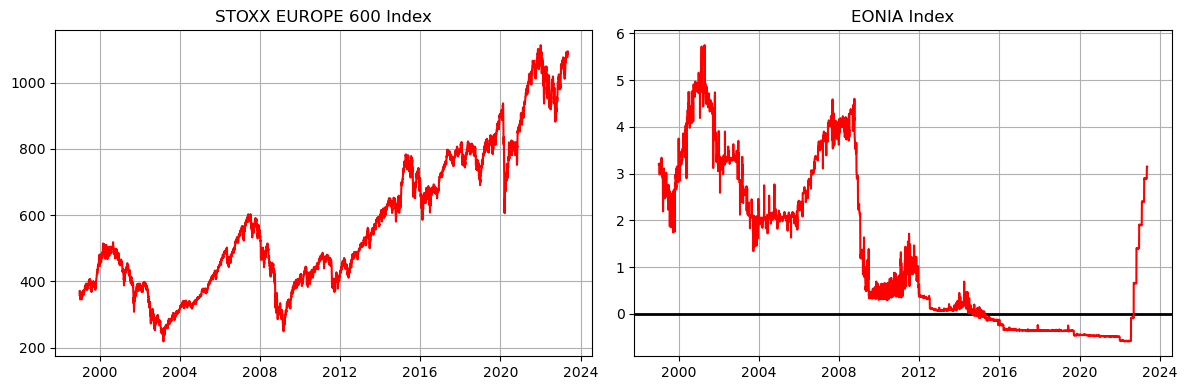

In [6]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr, c="r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(eonia,c="r")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

## Préparation des données

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
def monetarize(df:np.ndarray, nav:float, year:int, horizon:int=0)->pd.DataFrame:
    # Années précédente, à prendre le dernier jour
    tab_prec = df[str(year-1):str(year-1)]
    tab_prec["Loan"] = 100
    tab_prec = pd.DataFrame(tab_prec.iloc[-1]).T
    
    # Années en cours sur un horizon donné
    tab_suiv = df[str(year):str(year+horizon)]
    tab_suiv["Loan"] = 100
    
    tab = pd.concat([tab_prec, tab_suiv])

    rate = [x for x in tab.iloc[:,0]]
    table = np.zeros((len(rate)+1,1))
    table[0] = nav
    compteur = 0
    for elem in rate:
        compteur+=1
        table[compteur] = np.round(table[compteur-1] * (1 + elem/(365*100)),2)
    tab["Loan"] = np.round(table[0:-1],2)
    tab = tab.drop("EONIA Index", axis = 1)
    
    # Year Y
    
    tabl = tab[str(year):str(year+horizon)]
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    tabulate["EONIA Index"] = tabulate
    tabulate = tabulate.drop("Loan", axis = 1)
    
    return tabulate  

def particularyear(df:pd.DataFrame,year):
    tab = df
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T

    # Year Y
    tabl = tab[str(year):str(year)]  
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    return tabulate     
    
    
def normalize(df:pd.DataFrame, year:int, horizon:int=0)->pd.DataFrame:
    """
    This function has only one utility which is to normalize
    the dataframe df (which is the sxxr one) by dividing all the
    dataframe by the first value of sxxr.
    """
    
    S0 = pd.DataFrame(df.iloc[0]).T
    df = round((df/(float(S0.iloc[0,0])))*100,3)
    
    # Year Y-1
    tabn = df[str(year-1):str(year-1)]
    year_last_day = round(pd.DataFrame(tabn.iloc[-1]).T,3)
    
    # Year Y
    tab = df[str(year):str(year+horizon)]
    
    # Concatenate
    tabulate = pd.concat([year_last_day, tab])

    return tabulate

def concat(df1:pd.DataFrame, df2:pd.DataFrame):
    if all(df1.index == df2.index):
        tab = pd.concat([df1,df2],axis =1 )
    else:
        print("Please, be sure both DataFrame have the same index")
    return tab

def VL(df:pd.DataFrame, w:float):
    """
    This function allows to create the NAV dataframe
    The weight "w" should be between 0 and 1
    """
    df1 = pd.DataFrame(df.iloc[:,0]) # eonia
    df2 = pd.DataFrame(df.iloc[:,1]) # sxxr
    n = len(df)
    zer = np.zeros((n,1))
    df["VL"] = zer
    df["VL"] = df["EONIA Index"] * (1-w) + w * df["SXXR Index"]
    VL = pd.DataFrame(df["VL"])
    return VL

def get_list_protected(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab



<AxesSubplot:>

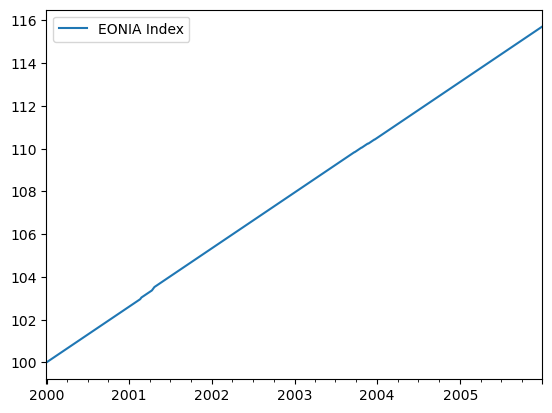

In [11]:
a = monetarize(eonia, 100, 2000, 5)
a.plot()

## CPPI lorsque le poid attribué à l'actif risqué est constant et égal à 90%

<AxesSubplot:>

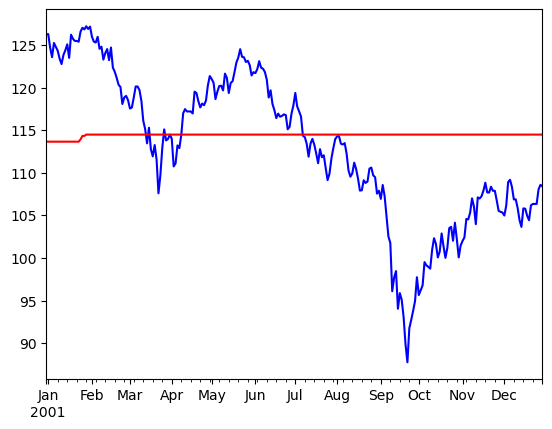

In [8]:
eonia_2000 = monetarize(eonia, 100,2000,5)
sxxr_2000 = normalize(sxxr,2000,5)

sxxr_1 = particularyear(sxxr_2000,2001)
eonia_1 = particularyear(eonia_2000,2001)
df_1 = concat(sxxr_1, eonia_1)

VL_1 = VL(df_1,0.9)
protect = get_list_protected(VL_1,2001,0.9,0)
protect
protect.iloc[:,0].plot(c="b")
protect.iloc[:,1].plot(c="r")

In [13]:
class CPPI:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
    
    def unifiedata(self, nav:float, year:int, horizon:int):
        eonia = monetarize(self.df2, nav,year,horizon)
        sxxr = normalize(self.df1,year,horizon)
        df = concat(sxxr, eonia)
        return df
    
    def protection(self, nav:float, year:int=2000, horizon:int=0, m:float=0.9):
        df_0 = self.unifiedata(nav,year,0)
        VL_0 = VL(df_0,0.9)
        protect_0 = get_list_protected(VL_0,year,m,0)
        
        return protect_0
    
    def unifiedprotection(self, nav:float,year:int=2000,horizon:int=0,m:float=0.9):
        # Year Y
        df_0 = self.protection(nav,year,0,m)
        df_0 = df_0.drop(df_0.index[-1])
        # Year Y+1
        df_1 = self.protection(nav,year+1,0,m)
        df_1 = df_1.drop(df_1.index[-1])
        # Year Y+2
        df_2 = self.protection(nav,year+2,0,m)
        df_2 = df_2.drop(df_2.index[-1])
        # Year Y+3
        df_3 = self.protection(nav,year+3,0,m)
        df_3 = df_3.drop(df_3.index[-1])
        # Year Y+4 (Final)
        df_4 = self.protection(nav,year+4,0,m)
        
        # Concat :
        df = pd.concat([df_0,df_1,df_2,df_3,df_4],axis=0)
        return df

In [19]:
cppi = CPPI(sxxr, eonia)
data = cppi.unifiedata(100,2000,5)
data

,SXXR Index,EONIA Index
1999-12-31,134.061,100.00
2000-01-03,133.434,100.01
2000-01-04,128.138,100.02
2000-01-05,124.976,100.03
2000-01-06,124.433,100.04
...,...,...
2005-12-26,124.681,115.68
2005-12-27,125.021,115.69
2005-12-28,124.856,115.70
2005-12-29,125.565,115.71


In [20]:
protect = cppi.unifiedprotection(100,2000,0,0.9)
if (min(protect.iloc[:,2]) <= 0):
    print("Faites attention, les coussins peuvent être négatifs ou nuls")
else:
    print("Les coussins sont positifs")


protect

Faites attention, les coussins peuvent être négatifs ou nuls


,VL,Plancher,Coussin
1999-12-31,130.6549,117.58941,13.06549
2000-01-03,130.0916,117.58941,12.50219
2000-01-04,125.3262,117.58941,7.73679
2000-01-05,122.4814,117.58941,4.89199
2000-01-06,121.9937,117.58941,4.40429
...,...,...,...
2004-12-27,98.8368,89.08749,9.74931
2004-12-28,98.9251,89.08749,9.83761
2004-12-29,98.9135,89.08749,9.82601
2004-12-30,98.9127,89.08749,9.82521


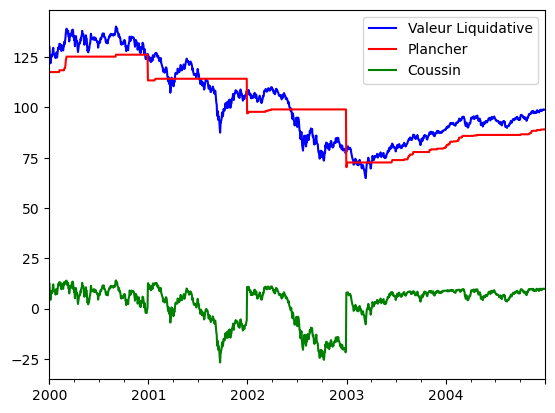

In [21]:
protect.iloc[:,0].plot(c="b", label="Valeur Liquidative")
protect.iloc[:,1].plot(c="r", label="Plancher")
protect.iloc[:,2].plot(c="g", label="Coussin")
plt.legend()

**Remarque** :
- Sur cette période de 5 ans (de 2000 à fin 2004), la VL peut être plus faible que le plancher, qui s'actualise chaque année.
- De ce fait, le coussin peut être négatif

## Exemple en modifiant le paramètre m

In [60]:
def dynamique(df:pd.DataFrame=protect, df2:pd.DataFrame=data,m:float=4):
    tab = df.copy()
    # Complement data
    tab["m"] = 0
    multiplier = [x for x in tab.iloc[:,3]]
    
    tab["SXXR"] = df2.iloc[:,0]
    tab["Eonia"] = df2.iloc[:,1]
    
    coussin = [x for x in tab.iloc[:,2]]
    
    count = 0
    for couss in coussin:
        if couss > 0:
            multiplier[count] = 0.9
        else:
            multiplier[count] = 0
        count += 1
    
    tab["m"] = multiplier
    tab["Coussin"] = coussin
    
    
    # Initialisation
    #tab["m"] = tab["SXXR"]/(tab["SXXR"]+tab["Eonia"]-tab["Plancher"])
    
    tab["VL"] = tab["m"] * tab["SXXR"] + (1-tab["m"]) * tab["Eonia"]
    
    tab = tab.drop(["m", "SXXR", "Eonia", "Plancher", "Coussin"], axis=1)
    # 
    #tab["Coussin 2"] = tab["SXXR"]*tab["m"]
    
    return tab

def get_list_protected_bis(df:pd.DataFrame = tab, plancher:float = 0.9):
    tab = df
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab

In [61]:
tab = dynamique()
test = get_list_protected_bis()
test

,VL,Plancher,Coussin
1999-12-31,130.6549,117.58941,13.06549
2000-01-03,130.0916,117.58941,12.50219
2000-01-04,125.3262,117.58941,7.73679
2000-01-05,122.4814,117.58941,4.89199
2000-01-06,121.9937,117.58941,4.40429
...,...,...,...
2004-12-27,99.8878,126.22446,-26.33666
2004-12-28,99.9761,126.22446,-26.24836
2004-12-29,99.9645,126.22446,-26.25996
2004-12-30,99.9637,126.22446,-26.26076


In [59]:
tab

,VL
1999-12-31,130.6549
2000-01-03,130.0916
2000-01-04,125.3262
2000-01-05,122.4814
2000-01-06,121.9937
...,...
2004-12-27,99.8878
2004-12-28,99.9761
2004-12-29,99.9645
2004-12-30,99.9637


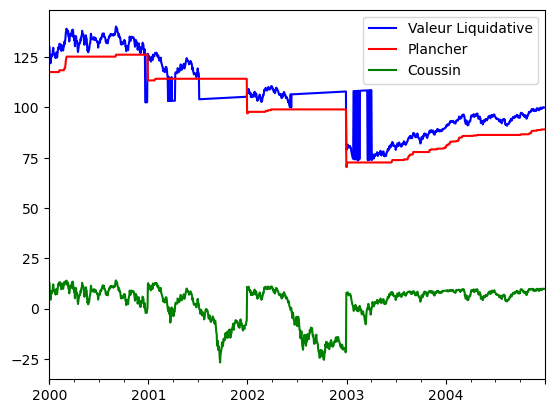

In [53]:
tab.iloc[:,0].plot(c="b", label="Valeur Liquidative")
tab.iloc[:,1].plot(c="r", label="Plancher")
tab.iloc[:,2].plot(c="g", label="Coussin")
plt.legend()